In [1]:
import operator

import numpy as np
import pandas as pd
import geopandas
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install dataframe_image selenium

In [3]:
import dataframe_image as dfi

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [5]:
# create dict mapping fips to iso3 country codes
ccodes = pd.read_csv("gcs://frsght/datasets/country_codes.csv")
fips_iso3_map = dict(zip(ccodes['fips (geonames)'].values, ccodes['ISO3 (geonames)'].values))

In [6]:
meta = {'transformer': {'path': 'gcs://frsght/model_predictions/chad_preds.csv',
                        'fips': 'Code', 'y_pred': 'class_preds',
                        'y_pred_proba': 'preds', 'y_true': 'Spike'},
        'xgboost': {'path': 'gcs://frsght/model_predictions/diana_preds.csv',
                    'fips': 'fips', 'y_pred': 'prediction',
                    'y_pred_proba': 'probabilities', 'y_true': 'lagged_spike'},
        'ffnn': {'path': 'gcs://frsght/model_predictions/evan_preds.csv',
                 'fips': 'fips', 'y_pred': 'preds',
                 'y_pred_proba': 'preds_proba', 'y_true': 'Spike_3'},
        'ensemble': {'fips': 'fips', 'y_pred': 'y_pred',
                     'y_pred_proba': 'y_pred_proba', 'y_true': 'y_true'}}

In [7]:
dft = pd.read_csv("gcs://frsght/model_predictions/chad_preds.csv").drop_duplicates()
dft['model'] = 'transformer'
dfx = pd.read_csv("gcs://frsght/model_predictions/diana_preds.csv").drop_duplicates()
dfx['yearmonth'] = pd.to_datetime(dfx['embedding_window']).dt.strftime("%Y%m")
dfx['model'] = 'xgboost'
dfn = pd.read_csv("gcs://frsght/model_predictions/evan_preds.csv").drop_duplicates()
dfx['yearmonth'] = pd.to_datetime(dfx['embedding_window']).dt.strftime("%Y%m")
dfn['model'] = 'ffnn'

In [8]:
dfs = {'transformer': dft, 'xgboost': dfx, 'ffnn': dfn}#, 'ensemble': dfe}

In [9]:
for m, df in dfs.items():
    df['iso3'] = df[meta[m]['fips']].map(fips_iso3_map)
    df = world.merge(df, right_on='iso3', left_on='iso_a3')
    df['yearmonth'] = df['yearmonth'].astype(str)
    bools = ['y_pred', 'y_true']
    for b in bools:
        df[meta[m][b]] = df[meta[m][b]].astype(bool)

    print('>>> ', m, df.shape)
    print(metrics.confusion_matrix(df[meta[m]['y_true']], df[meta[m]['y_pred']]), '\n')
    print(metrics.classification_report(df[meta[m]['y_true']], df[meta[m]['y_pred']]), '\n\n')
    dfs.update({m: df})

>>>  transformer (615, 20)
[[371 158]
 [ 46  40]] 

              precision    recall  f1-score   support

       False       0.89      0.70      0.78       529
        True       0.20      0.47      0.28        86

    accuracy                           0.67       615
   macro avg       0.55      0.58      0.53       615
weighted avg       0.79      0.67      0.71       615
 


>>>  xgboost (406, 16)
[[172 181]
 [ 15  38]] 

              precision    recall  f1-score   support

       False       0.92      0.49      0.64       353
        True       0.17      0.72      0.28        53

    accuracy                           0.52       406
   macro avg       0.55      0.60      0.46       406
weighted avg       0.82      0.52      0.59       406
 


>>>  ffnn (403, 15)
[[205 123]
 [ 31  44]] 

              precision    recall  f1-score   support

       False       0.87      0.62      0.73       328
        True       0.26      0.59      0.36        75

    accuracy                   

In [10]:
dft = dfs['transformer']
dfx = dfs['xgboost']
dfn = dfs['ffnn']


In [11]:
# create alternate df versions with same columns
_dft = dft.copy().rename(columns={'Code': 'fips', 'class_preds': 'y_pred',
                           'preds': 'y_pred_proba', 'Spike': 'y_true'})
_dft = _dft[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']]
_dfx = dfx.copy().rename(columns={'prediction': 'y_pred',
                           'probabilities': 'y_pred_proba', 'lagged_spike': 'y_true'})
_dfx = _dfx[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']]

_dfn = dfn.copy().rename(columns={'preds': 'y_pred',
                           'preds_proba': 'y_pred_proba', 'Spike_3': 'y_true'})
_dfn = _dfn[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']]

In [12]:
def mutate_alt(df):
    print(df.shape)
    df['iso3'] = df['fips'].map(fips_iso3_map)
    df['yearmonth'] = df['yearmonth'].astype(str)
    df['y_true'] = df['y_true'].astype(bool)
    df = df.set_index(['yearmonth', 'fips'])
    print(df.shape)
    return df

In [13]:
_dft = mutate_alt(_dft)
_dfx = mutate_alt(_dfx)
_dfn = mutate_alt(_dfn)

(615, 6)
(615, 5)
(406, 6)
(406, 5)
(403, 6)
(403, 5)


In [14]:
_dfs = dict(zip(['transformer', 'xgboost', 'ffnn'], [_dft, _dfx, _dfn]))

In [15]:
# join all model predictions
_dfa = _dft.merge(_dfx, left_index=True, right_index=True, suffixes=('_t', '_x'), how="outer").merge(_dfn, left_index=True, right_index=True, suffixes=('_a', '_n'), how="outer")

# make an 'ensemble' with mean prediction probabilities
dfe = pd.DataFrame({'y_pred_proba': _dfa[['y_pred_proba_t','y_pred_proba_x', 'y_pred_proba']].mean(axis=1),
                    'y_true': _dfa['y_true_t']})
dfe['y_pred'] = dfe['y_pred_proba'].round().astype(bool)

In [16]:
_dfa.shape

(716, 15)

In [17]:
# each set of predictions has different yearmonths, so many nulls
_dfa = _dfa.dropna(subset=['y_true', 'y_true_t', 'y_true_x'])

In [18]:
common_yearmonths = set.intersection(*[set(df.reset_index()['yearmonth'].unique()) for df in _dfs.values()])
print(common_yearmonths)

{'202211', '202212', '202301'}


In [19]:
_dfa.shape

(278, 15)

In [20]:
# true values of targets agree for only half of country-yearmonths
#https://stackoverflow.com/questions/22701799/pandas-dataframe-find-rows-where-all-columns-equal#comment99200717_22701944
sum(_dfa[['y_true', 'y_true_t', 'y_true_x']].eq(_dfa[['y_true', 'y_true_t', 'y_true_x']].iloc[:, 0], axis=0).all(axis=1))

196

In [21]:
_dfa[['y_true', 'y_true_t', 'y_true_x']].apply(set, axis=1).apply(len).mean()

1.2949640287769784

In [22]:
_dfa[_dfa['y_true'].ne(_dfa['y_true_t'])][['y_true', 'y_true_t', 'y_true_x']]

,,y_true,y_true_t,y_true_x
yearmonth,fips,,,


In [23]:
_dfa[_dfa['y_true_x'].ne(_dfa['y_true_t'])][['y_true', 'y_true_t', 'y_true_x']]

y_true y_true_t y_true_x
yearmonth fips                         
202211    AG    False    False     True
          AR     True     True    False
          BH    False    False     True
          BN     True     True    False
          CE     True     True    False
...               ...      ...      ...
202301    SA     True     True    False
          SF     True     True    False
          TO    False    False     True
          ZA     True     True    False
          ZI     True     True    False

[82 rows x 3 columns]

In [24]:
_dfa[_dfa['y_true'].ne(_dfa['y_true_x'])][['y_true', 'y_true_t', 'y_true_x']]

y_true y_true_t y_true_x
yearmonth fips                         
202211    AG    False    False     True
          AR     True     True    False
          BH    False    False     True
          BN     True     True    False
          CE     True     True    False
...               ...      ...      ...
202301    SA     True     True    False
          SF     True     True    False
          TO    False    False     True
          ZA     True     True    False
          ZI     True     True    False

[82 rows x 3 columns]

In [25]:
# list of sklearn.metrics functions that expect args `y_true` and `y_pred`
# nice explanations here: https://neptune.ai/blog/evaluation-metrics-binary-classification
# cohen kappa: how much better is your model over the random classifier that predicts based on class frequencies
# matthews: a correlation between predicted classes and ground truth
bin_metrics = ['f1_score', 'precision_score', 'recall_score',
               'cohen_kappa_score', 'matthews_corrcoef']

out = list()

for m, df in dfs.items():
    for metric in bin_metrics:
        fun = operator.methodcaller(metric, df[meta[m]['y_true']],
                                    df[meta[m]['y_pred']])
        out.append((m, metric, fun(metrics), 'max'))
    out.append((m, 'roc_auc_score', metrics.roc_auc_score(df[meta[m]['y_true']],
                                                          df[meta[m]['y_pred_proba']]), 'max'))
    
    tn, fp, fn, tp = metrics.confusion_matrix(df[meta[m]['y_true']],
                                              df[meta[m]['y_pred']]).ravel()
    
    # how many predictions out of all positive predictions were incorrect
    false_discovery_rate = fp/ (tp + fp)
    out.append((m, 'false_discovery_rate', false_discovery_rate, 'min'))
    
    # how many observations predicted as positive are in fact positive
    positive_predictive_value = tp/ (tp + fp)
    out.append((m, 'positive_predictive_value', positive_predictive_value, 'max'))
    
    # how many predictions out of all negative predictions were correct
    negative_predictive_value = tn/ (tn + fn)
    out.append((m, 'negative_predictive_value', negative_predictive_value, 'max'))
       
    false_positive_rate = fp / (fp + tn)
    out.append((m, 'false_positive_rate', false_positive_rate, 'min'))
    
    false_negative_rate = fn / (tp + fn)
    out.append((m, 'false_negative_rate', false_negative_rate, 'min'))
    
    true_positive_rate = tp / (tp + fn)
    out.append((m, 'true_positive_rate', true_positive_rate, 'max'))
    
    true_negative_rate = tn / (tn + fp)
    out.append((m, 'true_negative_rate', true_negative_rate, 'max'))

In [26]:
max_best = ['true_negative_rate', 'negative_predictive_value', 'true_positive_rate',
            'positive_predictive_value', 'f1_score', 'precision_score',
            'recall_score', 'cohen_kappa_score', 'matthews_corrcoef' 'roc_auc_score',]
min_best = ['false_negative_rate', 'false_discovery_rate', 'false_positive_rate',]

In [27]:
model_metrics = pd.DataFrame(out, columns=('model', 'metric', 'value', 'best'))

In [28]:
# max value for each metric
(model_metrics.loc[model_metrics[model_metrics.best=='max']
                   .groupby(["metric"])["value"]
                   .idxmax()][['metric', 'model', 'value']])

,metric,model,value
29,cohen_kappa_score,ffnn,0.143689
26,f1_score,ffnn,0.363636
30,matthews_corrcoef,ffnn,0.167227
21,negative_predictive_value,xgboost,0.919786
33,positive_predictive_value,ffnn,0.263473
27,precision_score,ffnn,0.263473
15,recall_score,xgboost,0.716981
18,roc_auc_score,xgboost,0.688065
12,true_negative_rate,transformer,0.701323
24,true_positive_rate,xgboost,0.716981


In [29]:
# min value for each metric
(model_metrics.loc[model_metrics[model_metrics.best=='min']
                   .groupby(["metric"])["value"]
                   .idxmin()][['metric', 'model', 'value']])

,metric,model,value
32,false_discovery_rate,ffnn,0.736527
23,false_negative_rate,xgboost,0.283019
9,false_positive_rate,transformer,0.298677


In [30]:
#| label: tbl-best-min-metrics-broken
#| layout-ncol: 1

# TODO not only do styles not work, but this makes one article
# column narrower than the other one :(

cm = sns.light_palette("red", as_cmap=True)
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Styler-Object-and-Customising-the-Display
# TODO styles/colors still not working? https://github.com/quarto-dev/quarto-cli/discussions/3964
styler = (model_metrics[model_metrics.best=='min'][['metric', 'model', 'value']]
            .sort_values('metric')
            .style
                .background_gradient(cmap=cm)
                .format(precision=3)
                .hide(axis="index"))
dfi.export(styler, 'imgs/tbl-best-min-metrics.png')
styler

metric,model,value
false_discovery_rate,transformer,0.798
false_discovery_rate,xgboost,0.826
false_discovery_rate,ffnn,0.737
false_negative_rate,transformer,0.535
false_negative_rate,xgboost,0.283
false_negative_rate,ffnn,0.413
false_positive_rate,transformer,0.299
false_positive_rate,xgboost,0.513
false_positive_rate,ffnn,0.375


In [31]:
#| label: tbl-best-max-metrics-broken
#| layout-ncol: 1

# TODO not only do styles not work, but this makes one article
# column narrower than the other one :(

cm = sns.light_palette("green", as_cmap=True)
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Styler-Object-and-Customising-the-Display
# TODO styles/colors still not working? https://github.com/quarto-dev/quarto-cli/discussions/3964
styler = (model_metrics[model_metrics.best=='max'][['metric', 'model', 'value']]
             .sort_values('metric')
             .style
                .background_gradient(cmap=cm)
                .format(precision=3)
                .hide(axis="index"))
dfi.export(styler, 'imgs/tbl-best-max-metrics.png', table_conversion="selenium")
styler

metric,model,value
cohen_kappa_score,ffnn,0.144
cohen_kappa_score,transformer,0.108
cohen_kappa_score,xgboost,0.088
f1_score,transformer,0.282
f1_score,ffnn,0.364
f1_score,xgboost,0.279
matthews_corrcoef,ffnn,0.167
matthews_corrcoef,xgboost,0.138
matthews_corrcoef,transformer,0.124
negative_predictive_value,xgboost,0.920


In [32]:
#| label: tbl-best-max-metrics
#| fig-cap: "Binary classification model metrics (max value is best)"
#| layout-ncol: 1

# TODO use of styler (above) messes up column widths,
# so just plain print for now
print(model_metrics[model_metrics.best=='max'][['metric', 'model', 'value']]
          .sort_values('metric')
          .to_string(index=False))

                   metric       model    value
        cohen_kappa_score        ffnn 0.143689
        cohen_kappa_score transformer 0.107707
        cohen_kappa_score     xgboost 0.087620
                 f1_score transformer 0.281690
                 f1_score        ffnn 0.363636
                 f1_score     xgboost 0.279412
        matthews_corrcoef        ffnn 0.167227
        matthews_corrcoef     xgboost 0.138041
        matthews_corrcoef transformer 0.123547
negative_predictive_value     xgboost 0.919786
negative_predictive_value transformer 0.889688
negative_predictive_value        ffnn 0.868644
positive_predictive_value     xgboost 0.173516
positive_predictive_value        ffnn 0.263473
positive_predictive_value transformer 0.202020
          precision_score     xgboost 0.173516
          precision_score        ffnn 0.263473
          precision_score transformer 0.202020
             recall_score     xgboost 0.716981
             recall_score        ffnn 0.586667
             

In [33]:
#| label: tbl-best-min-metrics
#| fig-cap: "Binary classification model metrics (min value is best)"
#| layout-ncol: 1

# TODO use of styler (above) messes up column widths,
# so just plain print for now
print(model_metrics[model_metrics.best=='min'][['metric', 'model', 'value']]
          .sort_values('metric')
          .to_string(index=False))

              metric       model    value
false_discovery_rate transformer 0.797980
false_discovery_rate     xgboost 0.826484
false_discovery_rate        ffnn 0.736527
 false_negative_rate transformer 0.534884
 false_negative_rate     xgboost 0.283019
 false_negative_rate        ffnn 0.413333
 false_positive_rate transformer 0.298677
 false_positive_rate     xgboost 0.512748
 false_positive_rate        ffnn 0.375000


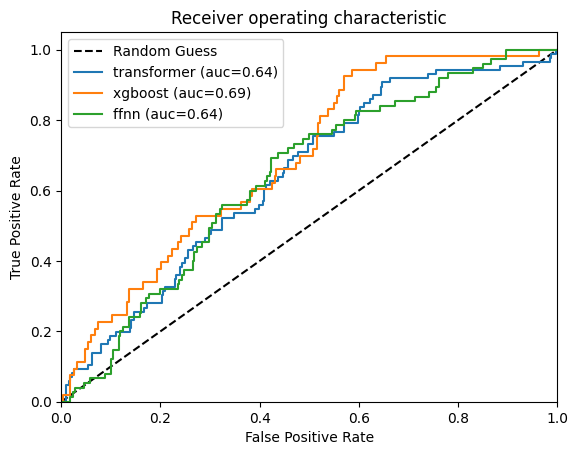

In [34]:
#| label: fig-roc
#| fig-cap: "Receiver operating characteristic"
#| fig-subcap: 
#|   - "Comparison of model ROC"
#| fig-alt:
#|   - "ROC plot of models"
#| layout-ncol: 1

plt.figure()
plt.plot([0,1],[0,1], "k--", label='Random Guess')

for m, df in dfs.items():
    fpr, tpr, _ = metrics.roc_curve(df[meta[m]['y_true']], df[meta[m]['y_pred_proba']])
    auc = metrics.roc_auc_score(df[meta[m]['y_true']], df[meta[m]['y_pred_proba']])
    plt.plot(fpr, tpr, label=f"{m} (auc={auc:.02f})")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
plt.legend(loc="best")
plt.savefig('imgs/fig-roc.png')
plt.show()

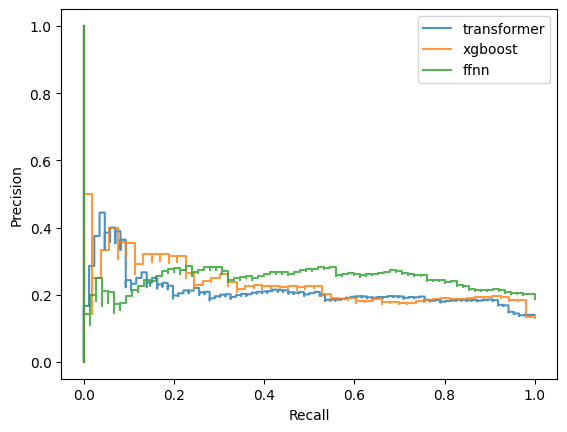

In [35]:
#| label: fig-prc
#| fig-cap: "Precision recall curve"
#| fig-subcap: 
#|   - "Comparison of model precision recall curves"
#| fig-alt:
#|   - "PRC plot of models"
#| layout-ncol: 1

ax = plt.gca()
for m, df in dfs.items():
    precision, recall, threshold = metrics.precision_recall_curve(df[meta[m]['y_true']], 
                                                                  df[meta[m]['y_pred_proba']])
    prd = metrics.PrecisionRecallDisplay(precision, recall)
    prd.plot(ax=ax, alpha=0.8, label=m)
plt.legend(loc="best")
plt.savefig('imgs/fig-prc.png')
plt.show()

In [36]:
for m, df in _dfs.items():
    print(df.shape)
    print(df.columns.values)

(615, 5)
['y_pred' 'y_pred_proba' 'y_true' 'model' 'iso3']
(406, 5)
['y_pred' 'y_pred_proba' 'y_true' 'model' 'iso3']
(403, 5)
['y_pred' 'y_pred_proba' 'y_true' 'model' 'iso3']


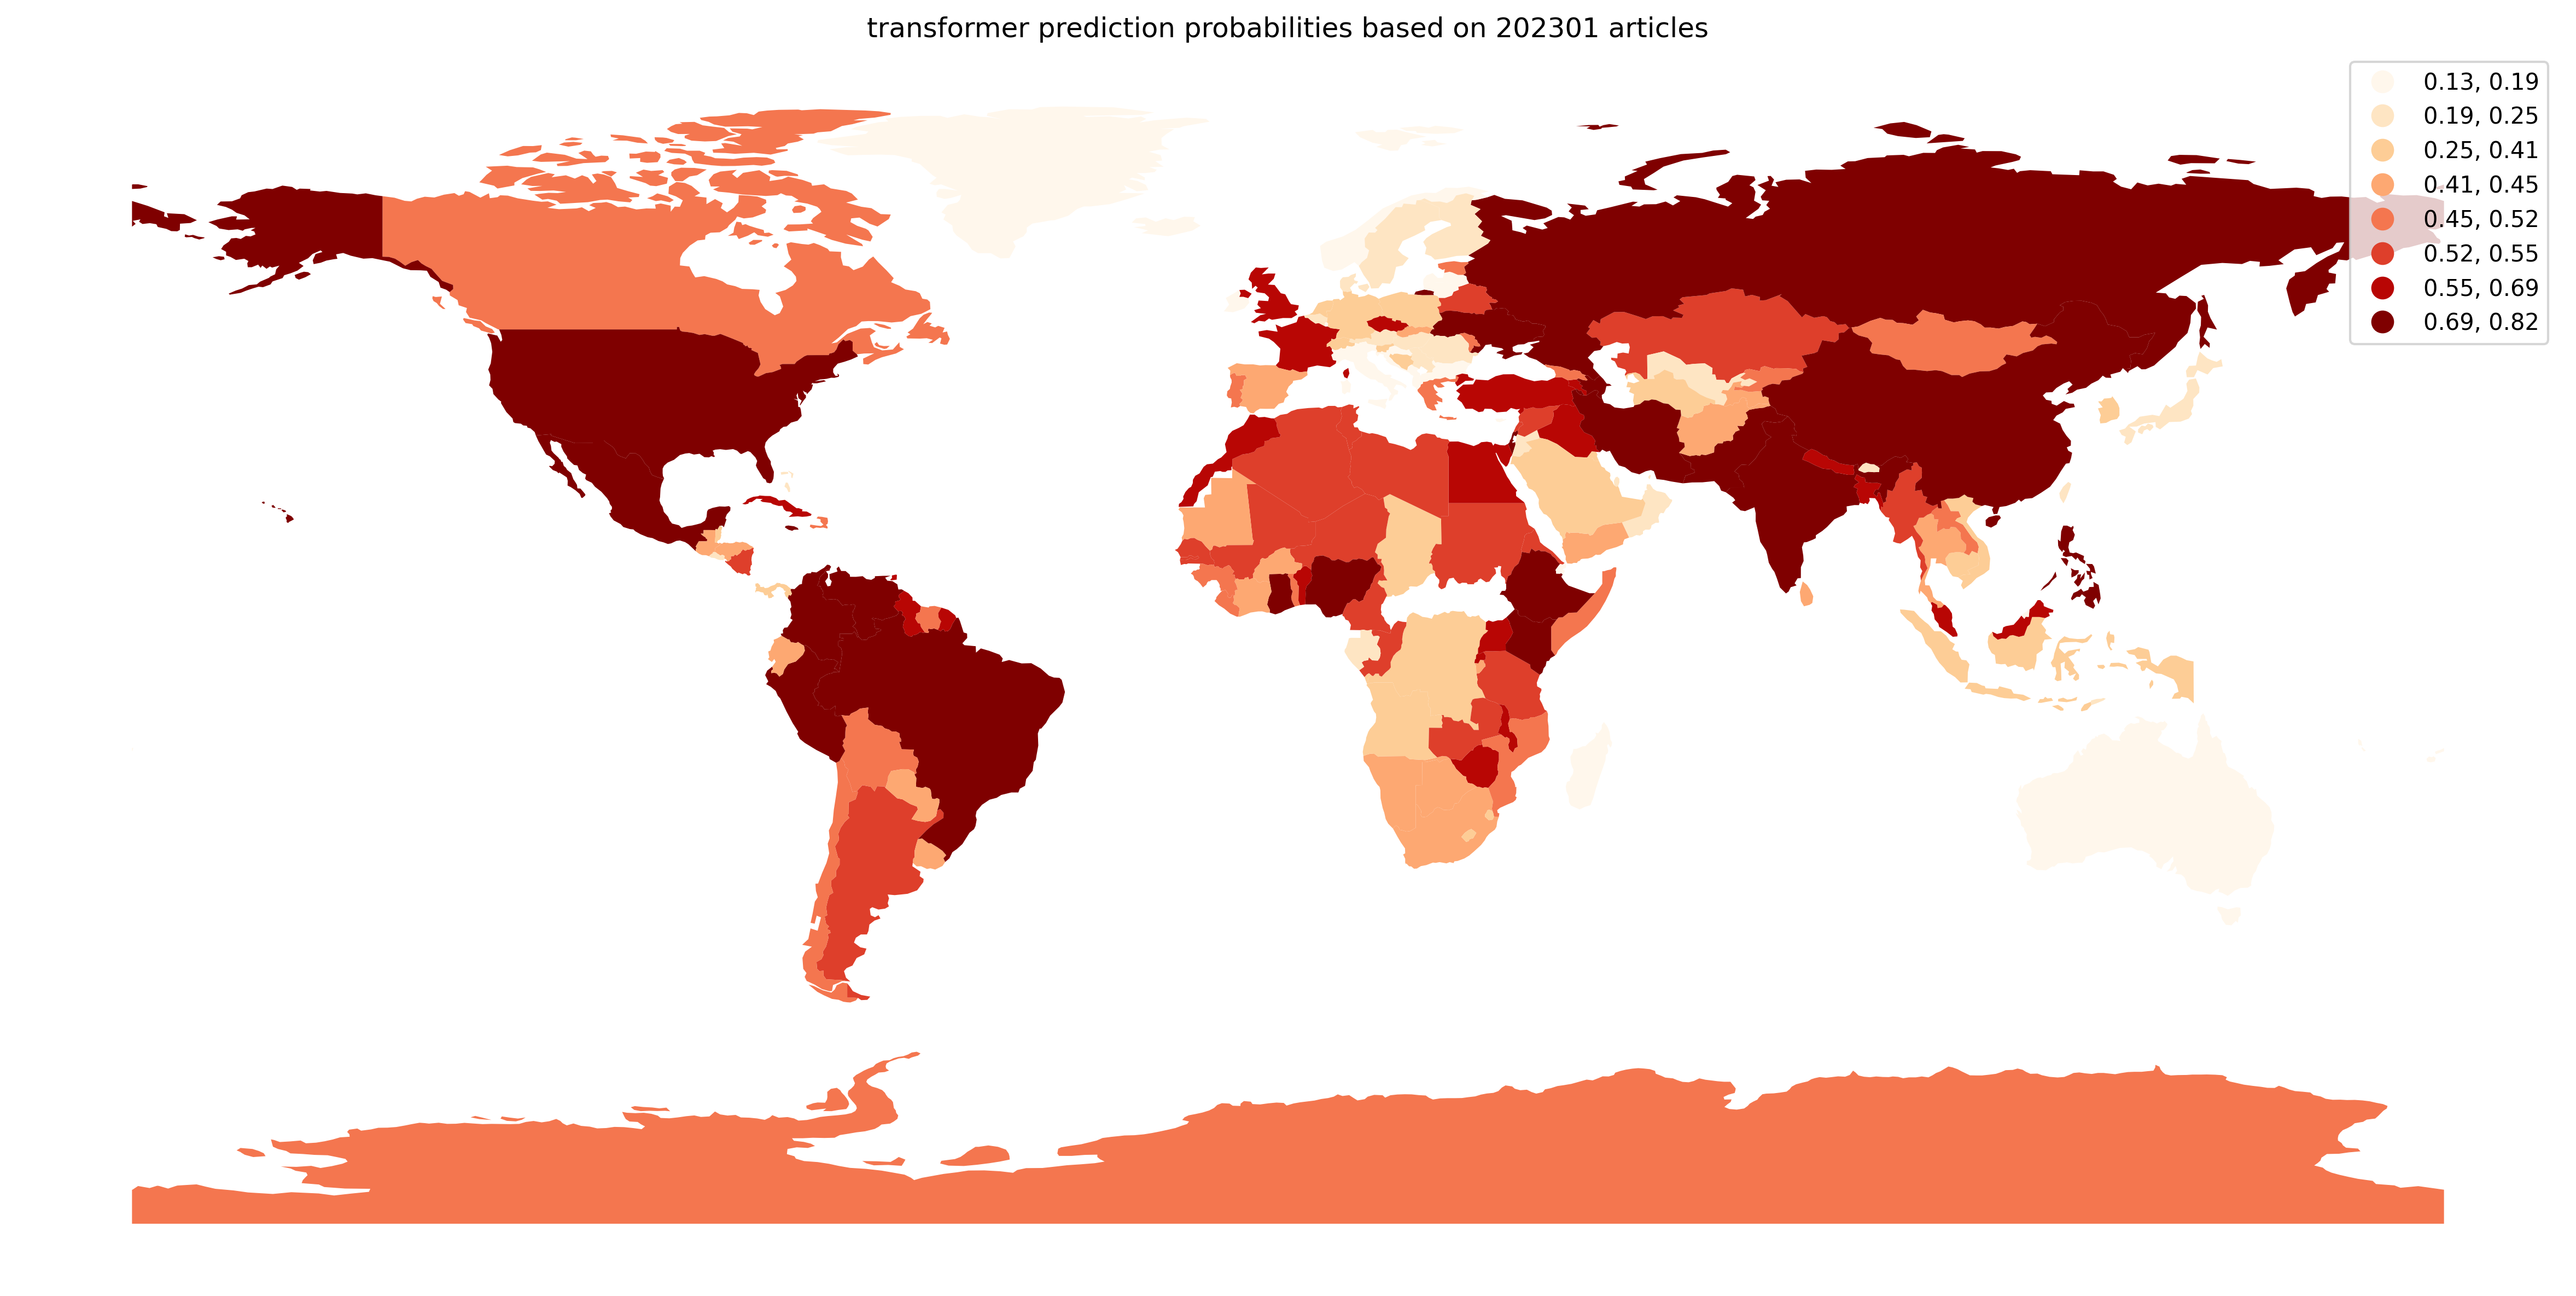

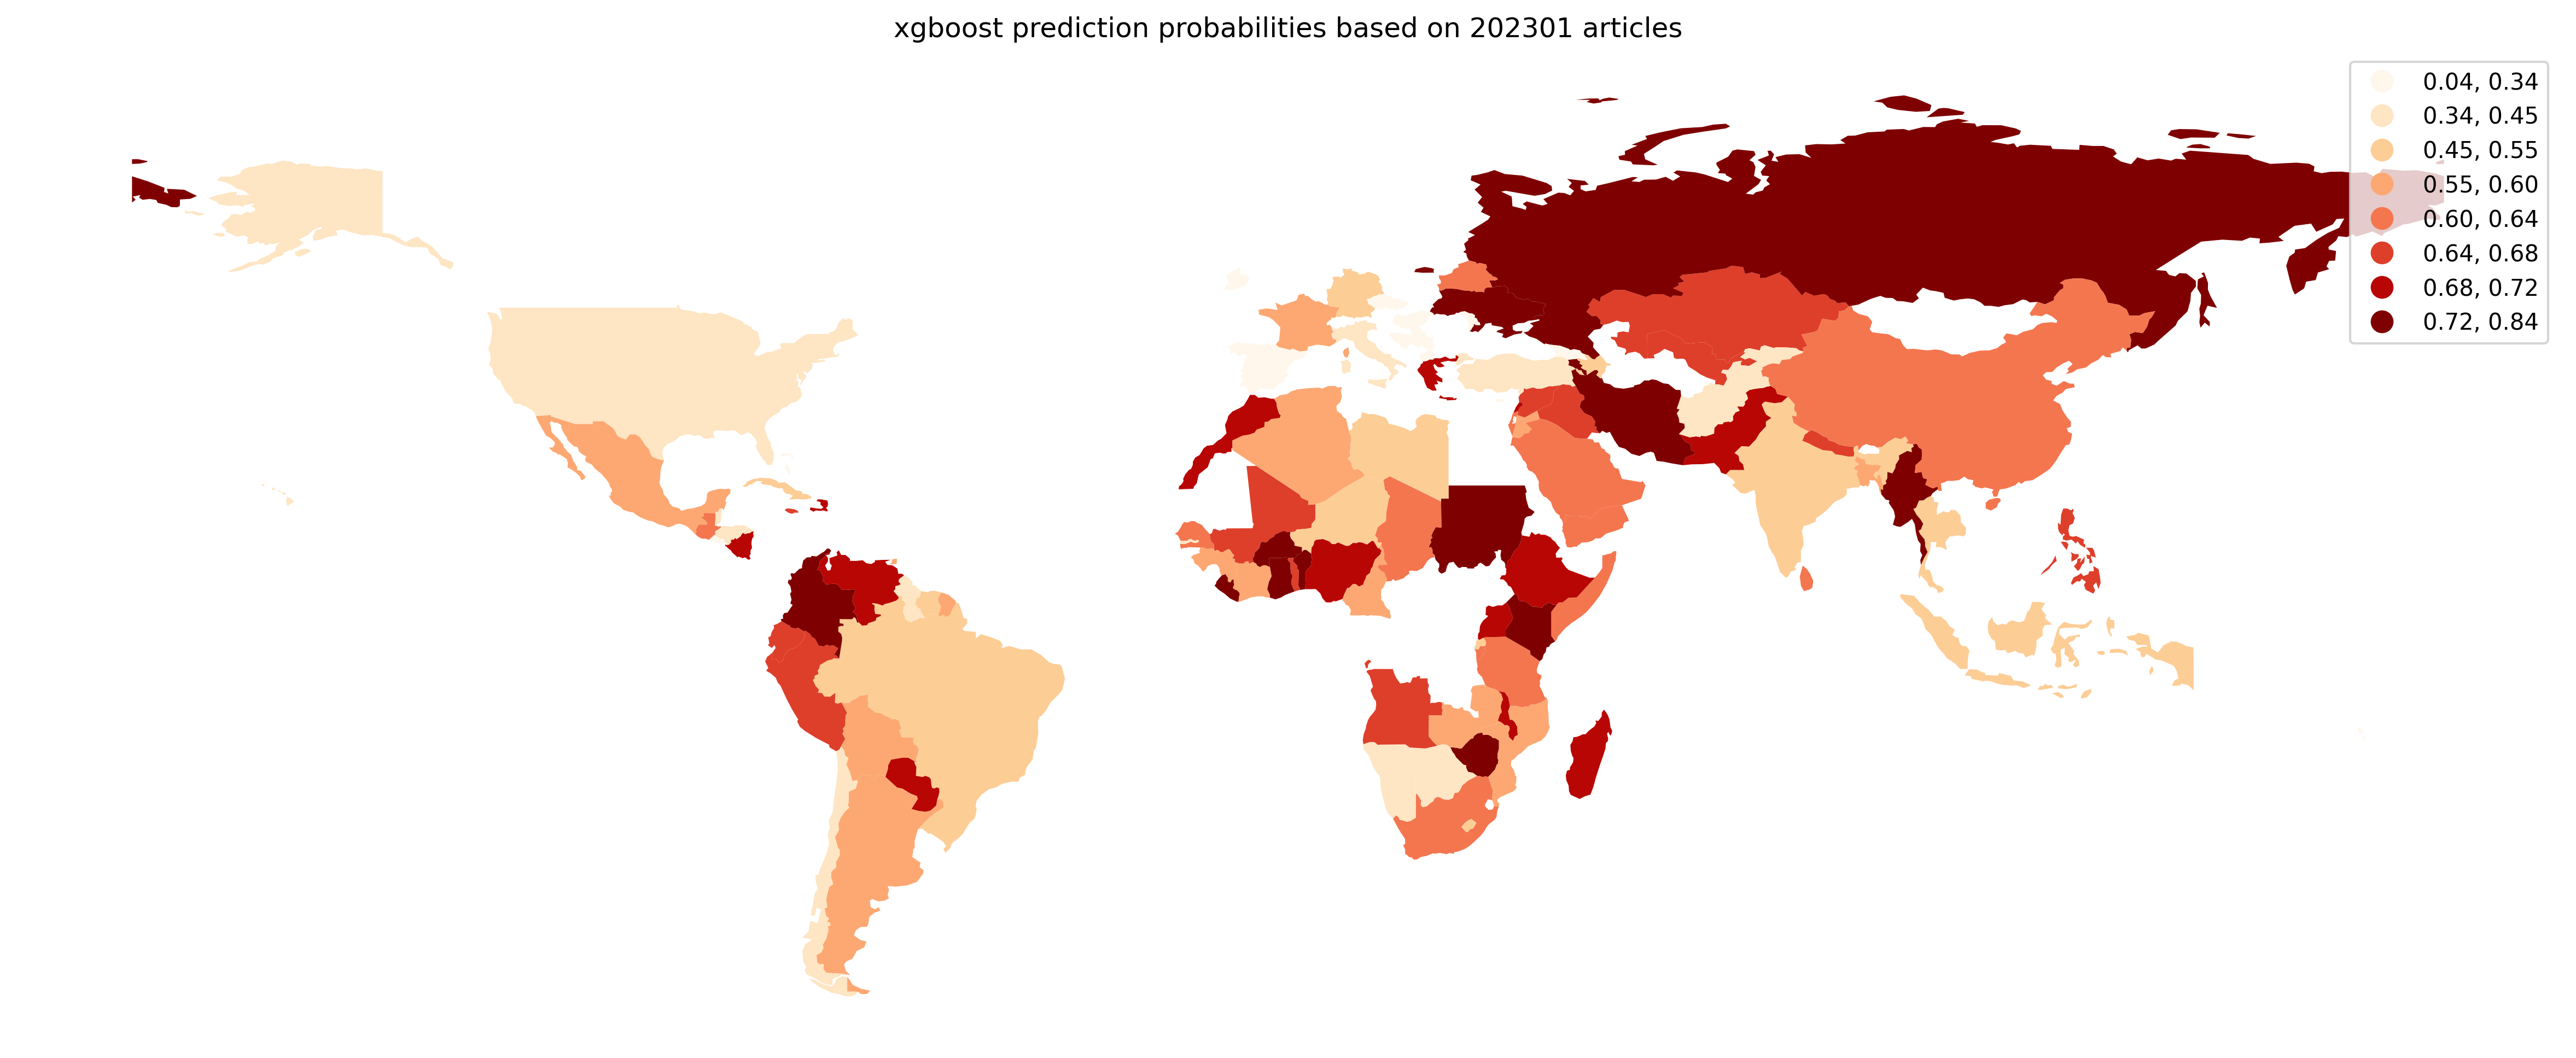

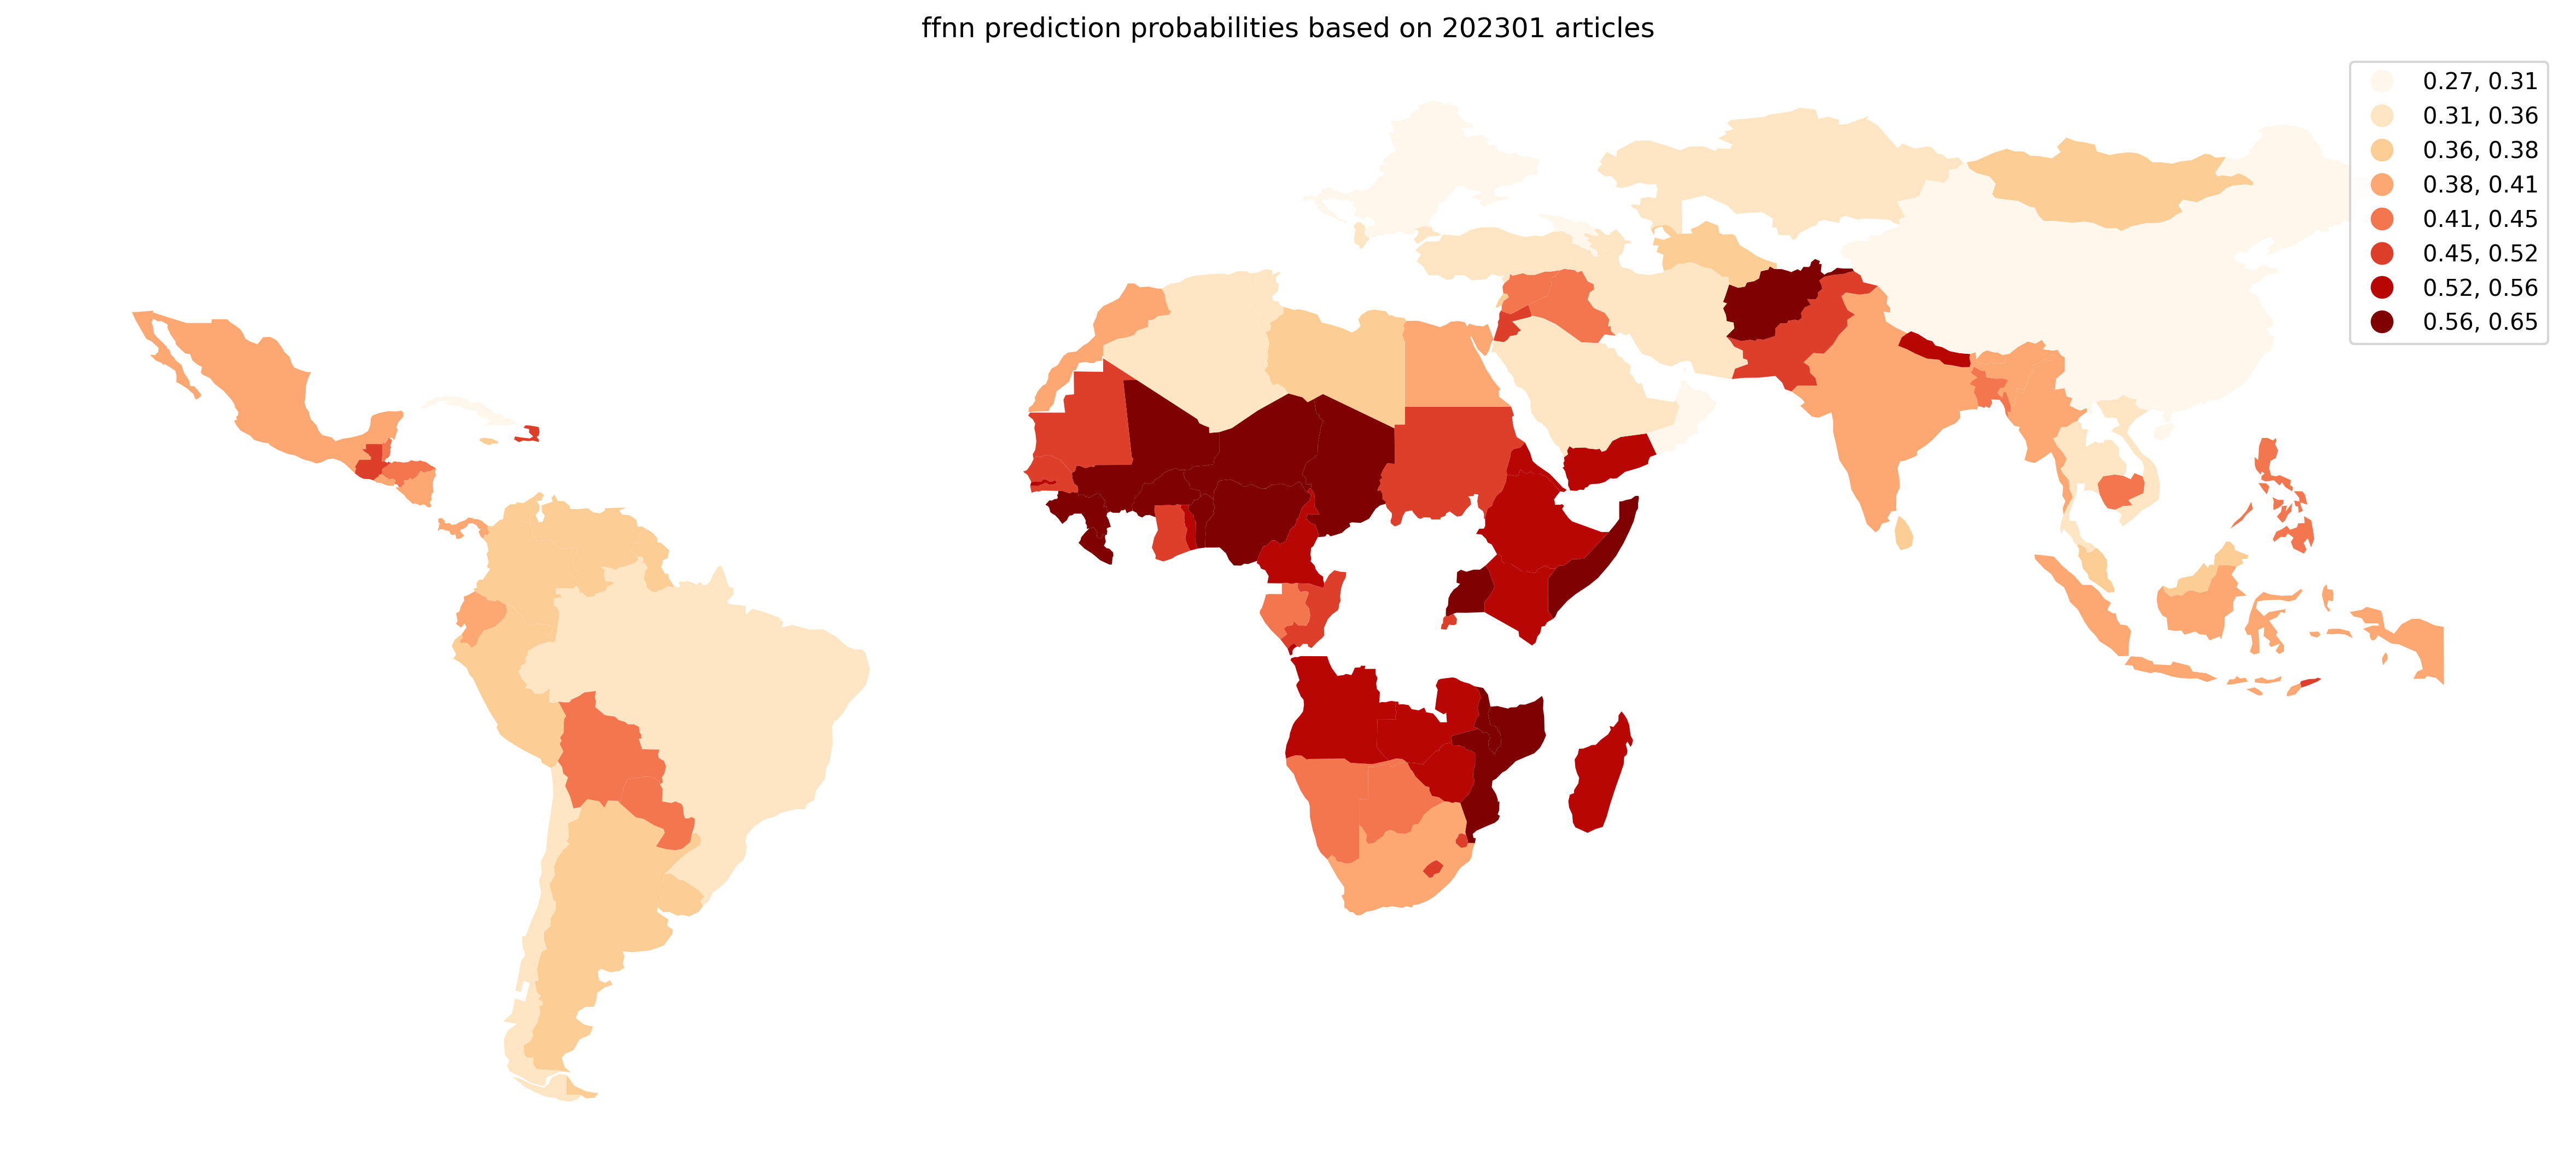

In [37]:
for m, df in _dfs.items():
    _df = df.reset_index()
    col = 'y_pred_proba'
    ym = '202301'
    _df = _df[_df['yearmonth'].isin([ym])]
    _df = world.merge(_df, right_on='iso3', left_on='iso_a3')

    fig, ax = plt.subplots(1, 1, figsize=(20, 18), dpi=300)
    ax.set_title(f"{m} prediction probabilities based on {ym} articles")
    _df.plot(column=col, ax=ax, scheme='QUANTILES', k=8, legend=True,
             cmap="OrRd")
    ax.set_axis_off();
    plt.savefig(f'imgs/fig-{col}-{m}-{ym}.png')

In [38]:
def tooltip_text(row):
    out = f"{row['iso3']}: &emsp;{row['y_true_t']} {row['y_true_x']} {row['y_true']}<br>"
    for m, pro, pre in [('transformer', 'y_pred_proba_t', 'y_pred_t'),
                        ('xgboost', 'y_pred_proba_x', 'y_pred_x'),
                        ('ffnn', 'y_pred_proba', 'y_pred')]:
        out += f"{m}: <br>&emsp;{row[pro]:.02f} ({row[pre]})<br>"
    return out

In [39]:
dfa = world.merge(_dfa.reset_index(), right_on='iso3', left_on='iso_a3')

In [40]:
dfa['tooltip'] = dfa.apply(tooltip_text, axis=1)

In [41]:
ym = '202301'
col = 'y_pred_proba'
_dfa = dfa[dfa['yearmonth'].isin([ym])]
#_dfa = _dfa.dropna()

In [42]:
print(dfa.shape)
print(dfa[dfa['yearmonth'].isin([ym])].shape)

(278, 24)
(79, 24)


In [43]:
_dfa.geometry[(_dfa.geometry.is_empty | _dfa.geometry.isna())]

GeoSeries([], Name: geometry, dtype: geometry)

In [45]:
_dfa.explore(
     column=col, # make choropleth based on this column
     tooltip="tooltip", # show "tooltip" value in tooltip (on hover)
     popup=True, # show all values in popup (on click)
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     cmap='OrRd',
     style_kwds=dict(color="darkgrey") # use darkgrey outline
)